# Demo 2: Selecting Scenarios of Bivariate Data

This example shows how to use the ScenarioSelector algorithm to select a maximal subset of observations of a bivariate random variable, so that the selected observations have a chosen mean.

You can install the scenarioselector package from the [Python Package Index](https://pypi.org/project/scenarioselector/) with the command `pip install scenarioselector`.

Let's begin by sampling $200$ observations from a bivariate uniform random variable on a unit square $[0, 1]\times[0, 1]$. We do this by independently sampling an array of uniforms on the unit interval $[0, 1]$, with shape $(200, 2)$.

In [1]:
import numpy as np; np.random.seed(0)

trials = 200
data = np.random.uniform(size=(trials, 2))

The two columns of `data` represent values of the bivariate random variable; each row represents an observation. The mean of the sampled data is very close to the center of the square, $(0.5, 0.5)$, with a small amount of sampling error.

In [2]:
print(data.mean(axis=0))

[0.50621286 0.48541966]


Let's instantiate a ScenarioSelector object, constructed from the uniformly sampled data, and a *target* mean $(0.7, 0.7)$.

\[The target mean you specify must lie within the convex hull of the 2-dimensional observations in the data set. In particular, it must lie within in the unit square $[0, 1]\times[0, 1]$. The scatter plots shown later give some helpful intuition.\]

In [3]:
from scenarioselector import ScenarioSelector

target_means = (0.7, 0.7)
selector = ScenarioSelector(data, means=target_means)

At this stage the scenario selection problem has been defined. We have not specified weights for the data in this example, so the ScenarioSelector assumes equal weights for each observation. We can calculate the mean of the data using the associated (normalised) probabilities.

In [4]:
print("Mean before optimization:", np.dot(selector.probabilities, data))

Mean before optimization: [0.50621286 0.48541966]


Call the ScenarioSelector's optimize method to run the modified simplex algorithm, which uses 'pivot' and 'flip' operations to solve a linear program. The linear program selects a maximal subset of observations from the original data set, such that the reduced data set has a bivariate mean of $(0.7, 0.7)$. 

In [5]:
selector.optimize()

report_string = "Selected {} of the {} observations, using {} pivots."
print(report_string.format(sum(selector.selected), trials,
                           selector.pivot_count))

Selected 77 of the 200 observations, using 4 pivots.


We calculate the reweighted mean of the observations to confirm the algorithm's success.

In [6]:
print("Mean after optimization:", np.dot(selector.probabilities, data))

Mean after optimization: [0.7 0.7]


You can inspect a variety of ScenarioSelector properties, both before and after the optimization:

| Property               | Description                                                    |
|-----------------------:|:---------------------------------------------------------------|
|  `probabilities`       | An array of probabilities associated with each scenario        |
|  `reduced_weights`     | An array of weights associated with each scenario              |
|  `selected`            | A Boolean array, indicating which scenarios have been selected |
|  `tableau`             | Condensed tableau for the simplex algorithm                    |
|  `pivot_count`         | Number of pivots operations used                               |
|  `lagrange_multiplier` | Lagrange multiplier for the dual problem                       |

For example, the reduced data set can be obtained by slicing the original data using the Boolean array of selected scenarios.

In [7]:
reduced_data = data[selector.selected]

print(reduced_data.mean(axis=0))

[0.7005051  0.70034999]


Notice that the mean of the reduced data set is very close to the target mean of $(0.7, 0.7)$. To make the mean precicely hit the target, `selector.probabilities` gives partial weights to two of the observations.

A scatter plot helps to visualise the scenario selection algorithm. Using the `lagrange_multiplier` we can delineate between those observations which have been selected or deselected. The red <font color='red'>x</font> represents the target mean. The blue dividing line goes through two of the data points.

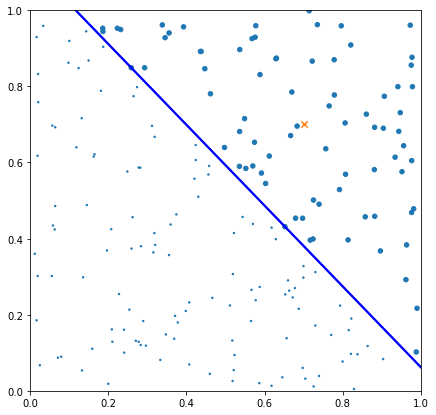

In [8]:
from scenarioselector.graphics import ScatterPlot

scatter_plot = ScatterPlot(data, means=target_means,
                           lagrange_multiplier=selector.lagrange_multiplier,
                           xlim=(0,1), ylim=(0,1))

We can track progress during the optimization by passing a callback function to the ScenarioSelector's optimize method. For example, we could use the callback function to record values of the Lagrange multiplier after each pivot. This enables us to give a visual demonstration of the algorithm.

\[We choose a significantly less efficient pivot rule because because it gives a better demonstration.\]

In [9]:
from scenarioselector.pivot_rule import PivotRule
from scenarioselector.pivot_variable import DantzigTwoPhase
from scenarioselector.pivot_scenarios import pivot_scenarios

multipliers_list = []

def callback(selector, i, element):
    multipliers_list.append(selector.lagrange_multiplier)

selector   = ScenarioSelector(data, means=target_means)
pivot_rule = PivotRule(DantzigTwoPhase, pivot_scenarios)
selector.optimize(callback, pivot_rule)

print(report_string.format(sum(selector.selected), trials,
                           selector.pivot_count))

Selected 77 of the 200 observations, using 123 pivots.


Using the `multipliers_list` collected by the callback function, we can animate the ScenarioSelector's progress during the optimization.

In [10]:
from matplotlib import rc; rc('animation', html='jshtml')
from matplotlib.animation import FuncAnimation

FuncAnimation(scatter_plot.fig, scatter_plot.animate,
              frames=len(multipliers_list), interval=50,
              repeat=False, blit=True,
              fargs=(multipliers_list,))

If you're curious, try constructing and using your own pivot rule.

In [ ]:
from scenarioselector.pivot_rule import PivotRule, PivotRuleSlowed
from scenarioselector.pivot_variable import (Dantzig, DantzigTwoPhase,
                                               MaxObjectiveImprovement, MaxObjectiveImprovementTwoPhase)
from scenarioselector.pivot_scenarios import pivot_scenarios, barrodale_roberts

pivot_rule = None # for example, try replacing 'None' with 'PivotRuleSlowed(Dantzig, barrodale_roberts)'

selector = ScenarioSelector(data, means=target_means)

multipliers_list.clear()
selector.optimize(callback, pivot_rule)

FuncAnimation(scatter_plot.fig, scatter_plot.animate,
              frames=len(multipliers_list), interval=50,
              repeat=False, blit=True,
              fargs=(multipliers_list,))